In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import numpy as np
import torch
print(torch.__version__)

1.9.0+cu111


In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0" to  "7"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
# !rm -rf pytorch-lib
# !git clone https://github.com/woolly-of-cv/pytorch-lib.git

In [6]:
import sys
sys.path.append(os.path.join(os.getcwd(), "pytorch-lib/"))
# print(sys.path)

In [7]:
from woollylib import main
from woollylib.utils.utils import get_device
# from woollylib.bp.vanila.backpropagation import train, test
from woollylib.bp.autocast.backpropagation import train, test

In [8]:
batch_size = 512
ricap_beta = 0.4
class_map = {
    'PLANE': 0,
    'CAR': 1,
    'BIRD': 2,
    'CAT': 3,
    'DEER': 4,
    'DOG': 5,
    'FROG': 6,
    'HORSE': 7,
    'SHIP': 8,
    'TRUCK': 9
}

# Enable or disable visualizations
show_summary = True
show_dataset_analyze = True

In [9]:
use_cuda, device = get_device()

In [10]:
from woollylib.utils.transform import BASE_PROFILE, get_transform # Get transforme functions
from woollylib.dataset.cifar.dataset import get_cifar_loader

train_profile = {
    'normalize': BASE_PROFILE['normalize'],
    'shift_scale_rotate': BASE_PROFILE['shift_scale_rotate'],
#         'rotate': BASE_PROFILE['rotate'],
    'pad_and_crop': BASE_PROFILE['pad_and_crop'],
#         'crop_and_pad': BASE_PROFILE['crop_and_pad'],
#         'random_brightness_contrast': BASE_PROFILE['random_brightness_contrast'],
    'horizontal_flip': BASE_PROFILE['horizontal_flip'],
#         'to_gray': BASE_PROFILE['to_gray'],
    'coarse_dropout': BASE_PROFILE['coarse_dropout'],
    'to_tensor':  BASE_PROFILE['to_tensor'],
}

train_profile['shift_scale_rotate']['rotate_limit'] = 7
train_profile['shift_scale_rotate']['p'] = 0.5

train_profile['pad_and_crop']['pad'] = 4
train_profile['pad_and_crop']['p'] = 1.0

#     train_profile['rotate']['limit'] = 5
#     train_profile['rotate']['p'] = 1.0

train_profile['coarse_dropout']['min_height'] = 8
train_profile['coarse_dropout']['min_width'] = 8
train_profile['coarse_dropout']['p'] = 1.0
train_profile['coarse_dropout']['max_height'] = 8
train_profile['coarse_dropout']['max_width'] = 8
#     train_profile['coarse_dropout']['fill_value'] = 0

normalize = {
    'normalize': BASE_PROFILE['normalize'],
    'to_tensor':  BASE_PROFILE['to_tensor'],
}

train_loader, test_loader = get_cifar_loader(get_transform(train_profile), get_transform(normalize), batch_size=batch_size, use_cuda=use_cuda)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
epochs = 24
lr = 0.045
max_lr = 0.45
steps_per_epoch = len(train_loader)
dropout = False
drop_ratio = 0.1
use_l1 = False
lambda_l1 = 1e-7
min_momentum = 0.9
momentum = 0.9
weight_decay = 0.0005
weight_decay = weight_decay # / batch_size

norm='bn'
ctype='vanila'
train_function=train
test_function=test

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("Dropout Ratio:", drop_ratio)
print("Momentum:", momentum)
print("Weight Decay:", weight_decay)
print("Use L1:", use_l1)
print("L1 Lambda:", lambda_l1)
print("RICAP Beta", ricap_beta)

Using Device: cuda
Epochs: 24
Lr: 0.045
Max Lr: 0.45
Batch Size: 512
Dropout: False
Dropout Ratio: 0.1
Momentum: 0.9
Weight Decay: 0.0005
Use L1: False
L1 Lambda: 1e-07
RICAP Beta 0.4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

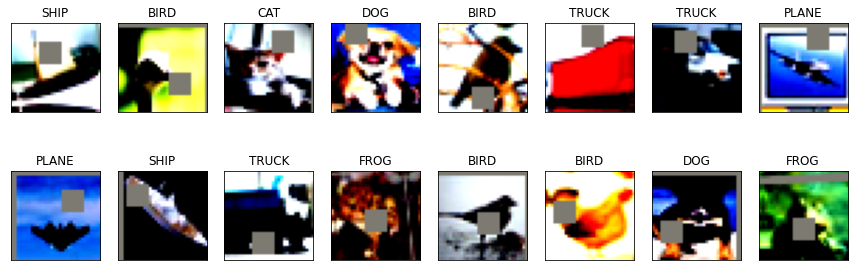

In [12]:
from woollylib.main import get_samples_visualize
get_samples_visualize(show_dataset_analyze, train_loader, class_map)

In [13]:
# from woollylib.models.custom.custom_resnet import CustomResNet
# from woollylib.main import get_optimizer
# from torch_lr_finder import LRFinder

# # Create model instance based on parameter which one to use
# model = CustomResNet(norm=norm, ctype=ctype).to(device)
# optimizer, criteria = get_optimizer(model, lr, momentum, weight_decay, device)

# lr_finder = LRFinder(model, optimizer, criteria, device=device)
# lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=100, step_mode="linear")
# lr_finder.plot(log_lr=False)
# lr_finder.reset()

In [14]:
from woollylib.models.custom.custom_resnet import CustomResNet
# from woollylib.models.transform.spatial_transformer import SpatialTransformer
from woollylib.main import get_optimizer, get_scheduler
from woollylib.utils.utils import initialize_weights, print_summary
from torch.cuda.amp import GradScaler

scaler = GradScaler()
ctrain = train_function(use_l1=use_l1, lambda_l1=lambda_l1)

# Create model instance based on parameter which one to use
model = CustomResNet().to(device)

optimizer, criteria = get_optimizer(model, lr, momentum, weight_decay, device)

custom_scheduler= get_scheduler(epochs, lr, max_lr, min_momentum, momentum, optimizer, steps_per_epoch)


from woollylib.training import Training
# Create instance of trainer with all params
trainer = Training(
    model,
    optimizer,
    criteria,
    custom_scheduler,
    ctrain,
    test_function,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout,
    scaler
)

if show_summary:
    print_summary(model, input_size=(3, 32, 32))
#     print_modal_summary(trainer.model)

# Run trainer
trainer.run()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
          WyConv2d-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
          WyConv2d-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
       BatchNorm2d-8          [-1, 128, 16, 16]             256
            Conv2d-9          [-1, 128, 16, 16]         147,456
         WyConv2d-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]         147,456
         WyConv2d-13          [-1, 128, 16, 16]               0
      BatchNorm2d-14          [-1, 128,

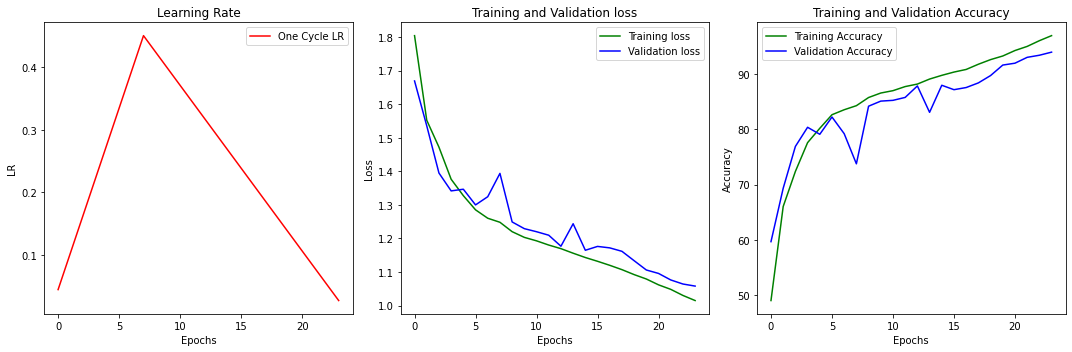

Confusion matrix, without normalization


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Incorrect Predictions 598


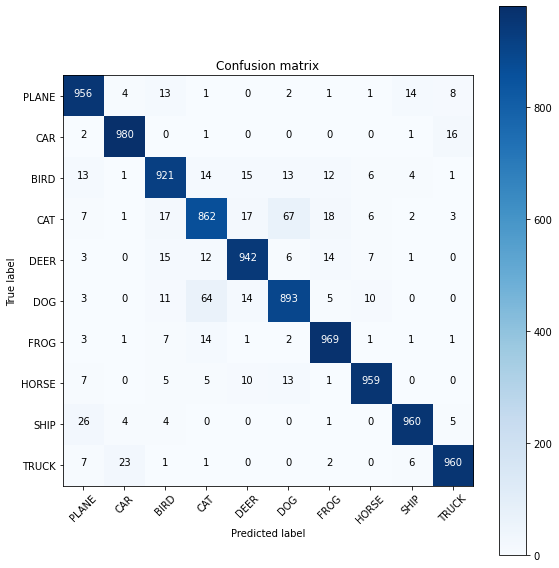

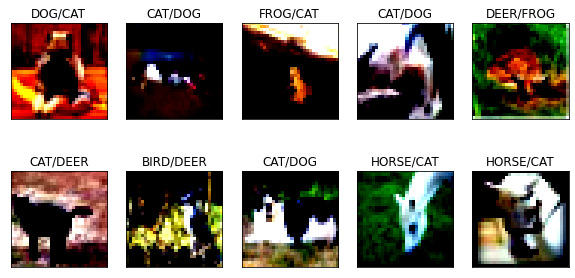

In [15]:
# Visualize network performance

from woollylib.utils.visualize import plot_network_performance
from woollylib.utils.utils import get_incorrrect_predictions
from woollylib.utils.visualize import plot_incorrect_predictions

from woollylib.utils.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from woollylib.utils.visualize import plot_confusion_matrix


#     trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

all_preds, all_targets = get_all_predictions(trainer.model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)

incorrect = get_incorrrect_predictions(trainer.model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)

In [16]:
# from woollylib.utils.gradcam.compute import compute_gradcam

# count = 10
# for i, (image, label, pred, output) in enumerate(incorrect):
#     compute_gradcam(model, class_map, image, label, pred, device=device)
#     if i == count-1:
#         break

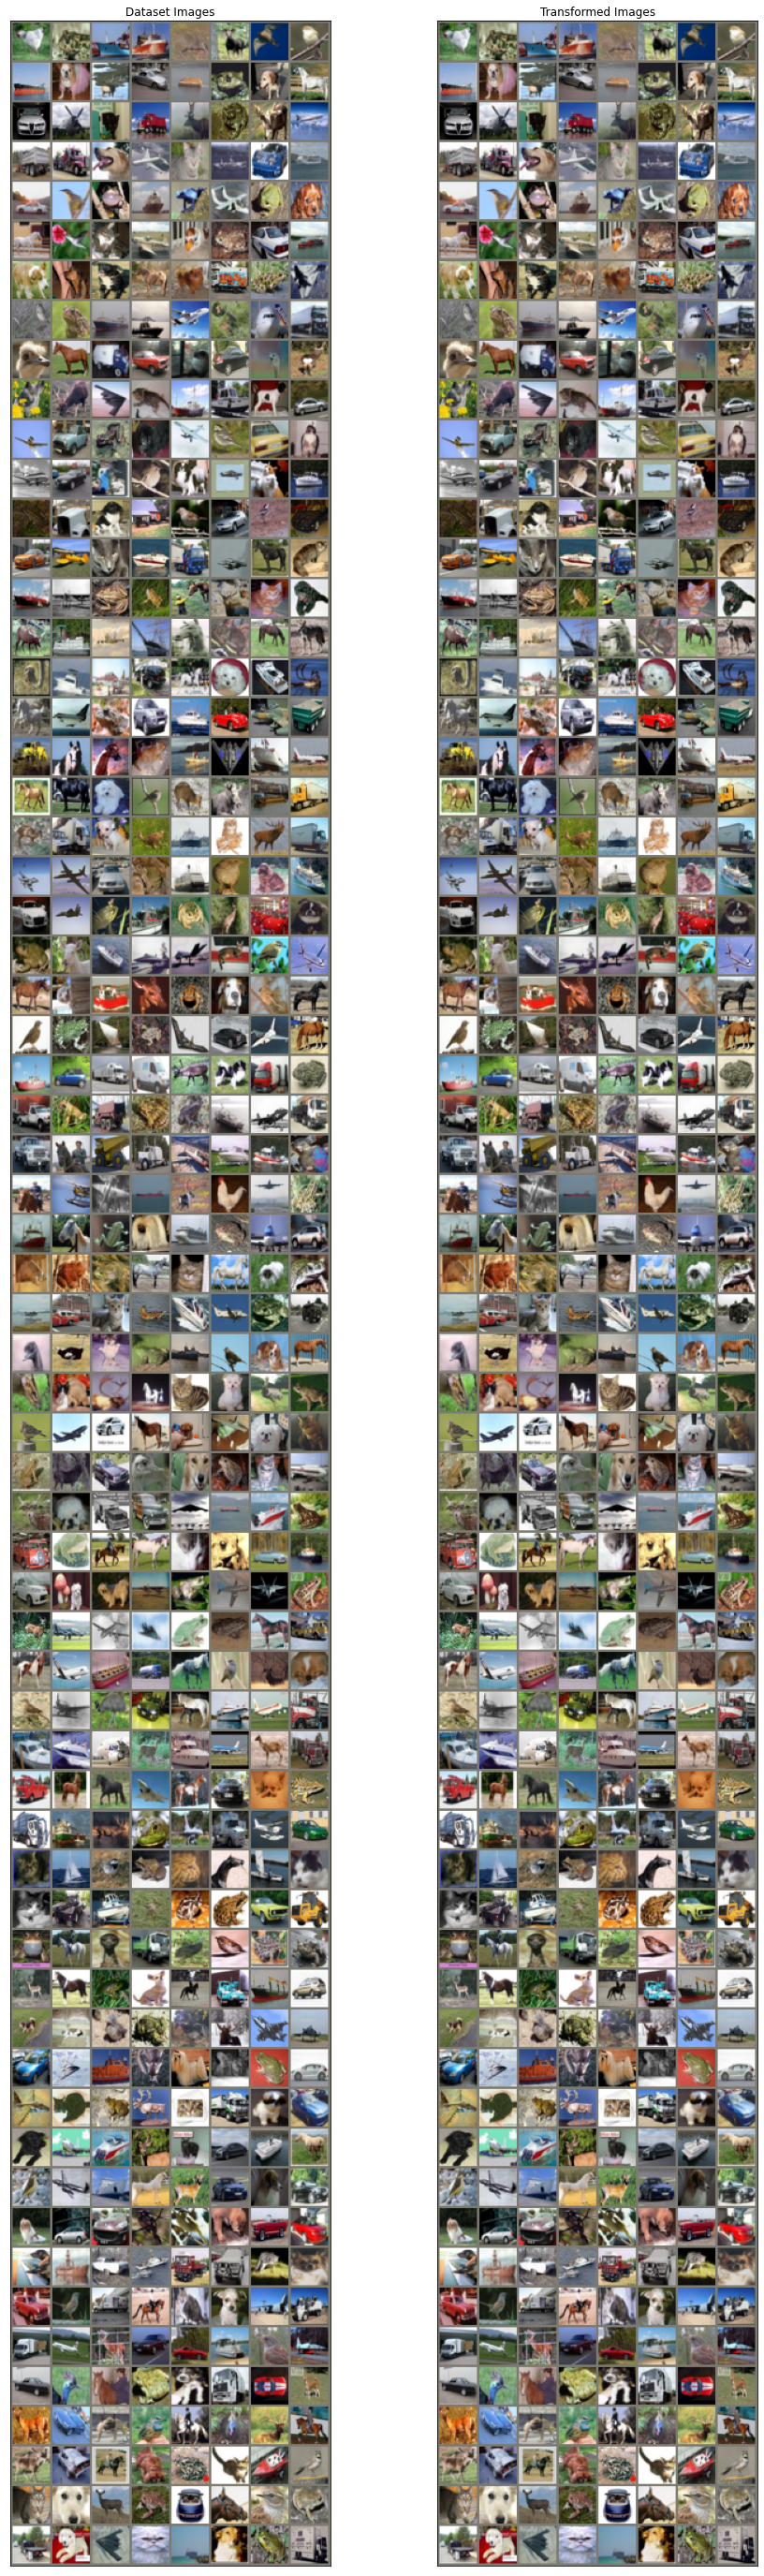

In [17]:
from __future__ import print_function
import torchvision
import matplotlib.pyplot as plt

plt.ion()   # interactive mode

def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.

fig = plt.figure(figsize=(15, 50))

def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
        ax.imshow(in_grid)
        ax.set_title('Dataset Images')

        ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
        ax.imshow(out_grid)
        ax.set_title('Transformed Images')

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()